In [1]:
import copy
import os
import time

import joblib
from fastfusion import Specification
from fastfusion.frontend.architecture import Leaf, Memory
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_sims
from fastfusion.mapper.metrics import Metrics
from fastfusion.mapper.FFM.joining.sim import SIM
from fastfusion.mapper.FFM.joining.simexplore import join_sims
import fastfusion.mapper.FFM.exploration.mapper_one_einsum as mapper_one_einsum

from fastfusion.mapper.FFM.exploration.mapping_filter_tags.ffmt import get_ffmt_tag
from fastfusion.mapper.FFM.exploration.mapping_filter_tags.onesplit import get_one_split_tag
from fastfusion.mapper.FFM.pareto import PartialMappings
import pickle as pkl

metrics = Metrics.ENERGY
archname = "four_level"

@joblib.memory.Memory(location='./cache', verbose=2).cache
def get_fused_mappings(
    renames_name: str,
    glb_size_scale: float = 1.0,
    reg_x_y_scale: float = 1.0,
) -> PartialMappings:
    cachkey = f"./cache/{renames_name}_{glb_size_scale}_{reg_x_y_scale}.pkl"
    if os.path.exists(cachkey):
        return pkl.load(open(cachkey, "rb"))
    spec = Specification.from_yaml(
        f"architecture/{archname}.arch.yaml",
        f"workloads/mha_full.workload.yaml",
        f"workloads/mha_full{renames_name}.renames.yaml"
    )
    spec2 = copy.deepcopy(spec)
    glb: Memory = spec2.architecture.nodes["GlobalBuffer"]
    glb.attributes.size = f"round({glb.attributes.size} * {glb_size_scale})"
    glb.attributes.energy_scale = (glb_size_scale ** (1.56 / 2))
    llb: Memory = spec2.architecture.nodes["LocalBuffer"]
    llb.attributes.size = f"round({glb.attributes.size} * {glb_size_scale})"
    llb.attributes.energy_scale = (glb_size_scale ** (1.56 / 2))
    reg: Memory = spec2.architecture.nodes["Register"]
    reg.spatial.fanout["X"] = round(reg.spatial.fanout["X"] * reg_x_y_scale)
    reg.spatial.fanout["Y"] = round(reg.spatial.fanout["Y"] * reg_x_y_scale)

    spec2.calculate_component_energy_area()
    flattened_architecture = spec2.get_flattened_architecture()
    sims, decompress_data = get_sims(spec2, flattened_architecture, metrics=metrics)
    mappings = join_sims(sims, spec2, flattened_architecture)
    mappings.decompress(decompress_data)
    pkl.dump(mappings, open(cachkey, "wb"))
    return mappings

result = {
    # (0.25, "Fusion"): get_fused_mappings("", 0.25),
    # (0.5, "Fusion"): get_fused_mappings("", 0.5),
    # (1, "Fusion"): get_fused_mappings("", 1.0),
    # (2, "Fusion"): get_fused_mappings("", 2.0),
    # (4, "Fusion"): get_fused_mappings("", 4.0),
    (0.25, "No Fusion"): get_fused_mappings("_no_fusion", 0.25),
    (0.5, "No Fusion"): get_fused_mappings("_no_fusion", 0.5),
    (1, "No Fusion"): get_fused_mappings("_no_fusion", 1.0),
    (2, "No Fusion"): get_fused_mappings("_no_fusion", 2.0),
    (4, "No Fusion"): get_fused_mappings("_no_fusion", 4.0),
}
for k, v in result.items():
    print(f'{k}: {v.data["metric_Energy"].min()}')


________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-4217873104.get_fused_mappings...
get_fused_mappings('_no_fusion', 0.25)


FileNotFoundError: Could not find file workloads/mha_full_no_fusion.renames.yaml

TypeError: unhashable type: 'numpy.ndarray'

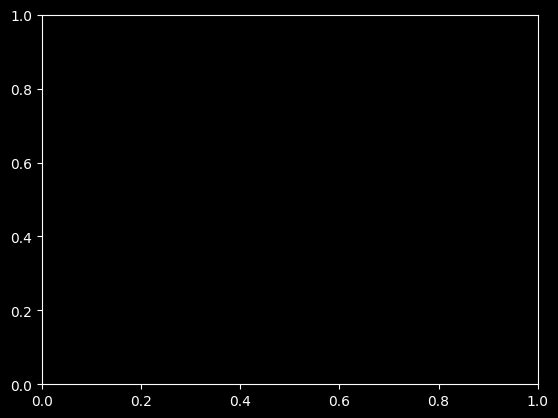

In [2]:
import matplotlib.pyplot as plt

plt.plot(list(result.keys()), [v.data["metric_Energy"].min() for v in result.values()])
plt.show()